In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
   
from sklearn.cluster import KMeans 

from tensorflow.keras.models import load_model
import tensorflow as tf

from gtts import gTTS
from googletrans import Translator
from playsound import playsound  

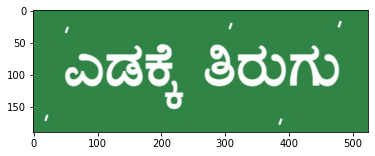

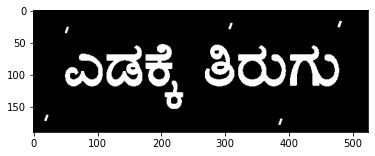

In [2]:
img=cv2.imread("D:/Engineering/New folder/seg_images/tl.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #converting to RGB format
img_col=img.copy()

plt.imshow(img)
plt.show()
def preprocess(image):
    img_gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) #converting to grayscale
    
    #otsu's method of binarization
    thresh,img_bin=cv2.threshold(img_gray,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return img_bin

img_bin=preprocess(img)
plt.imshow(img_bin,cmap='gray')

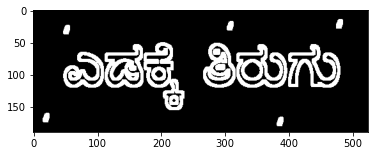

In [3]:
img_canny=cv2.Canny(img_bin,90,90)
kernel=np.ones((5,5))
img_dil=cv2.dilate(img_canny,kernel,iterations=1)
plt.imshow(img_dil,cmap='gray')

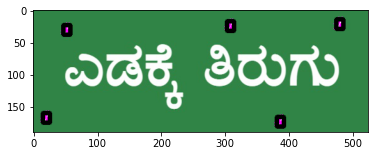

In [4]:
#get noise and drawing bounding box around noise regions
def getNoise(img_dil,img_contour):
    noise=[]
    contours,hierarchy=cv2.findContours(img_dil,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area<1000:
            noise.append(cnt)
            cv2.drawContours(img_contour,cnt,-1,(255,0,255),7)
            peri = cv2.arcLength(cnt,True)
            approx= cv2.approxPolyDP(cnt,0.02*peri,True)
            x,y,w,h=cv2.boundingRect(approx)
            cv2.rectangle(img_contour,(x,y),(x+w,y+h),(0,0,0),5)
    return noise

img_contour=img.copy()
noise=getNoise(img_dil,img_contour)
plt.imshow(img_contour)

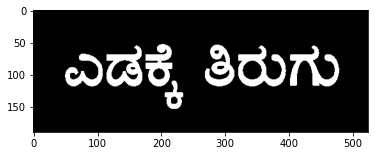

In [5]:
#filling the noise region with black pixels
cv2.drawContours(img_bin, noise, -1, color=(0,0,0), thickness=cv2.FILLED)
img_hor=np.array(img_bin)
plt.imshow(img_bin,cmap='gray')

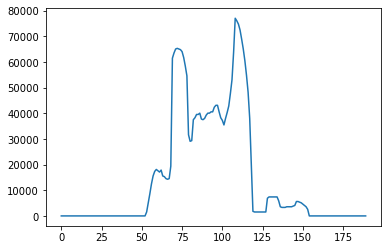

In [6]:
#histogram of horizontal sum of pixels 
hist_col = np.sum(img_bin, axis = 1)
plt.plot(hist_col)
plt.show()

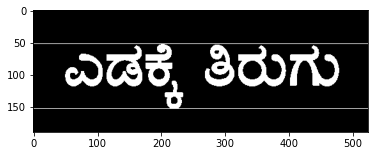

In [7]:
#drawing horizontal lines were the sum of pixels is less than the threshold
thresh = 1
H,W = img_hor.shape[:2]
uppers = [y for y in range(H-1) if hist_col[y]<=thresh and hist_col[y+1]>thresh]
lowers = [y for y in range(H-1) if hist_col[y]>thresh and hist_col[y+1]<=thresh]

for y in uppers:
    cv2.line(img_hor, (0,y), (W, y), (255,255,255), thickness=1)

for y in lowers:
    cv2.line(img_hor, (0,y), (W, y), (255,255,255), thickness=1)

plt.imshow(img_hor,cmap='gray')

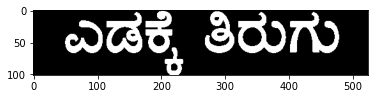

In [8]:
#getting the cordinates of the ROI
line_wise=[]
for i in range(len(uppers)):
    temp=[0,uppers[i],W,lowers[i]-uppers[i]]
    line_wise.append(temp)

def crop(img,co_ord,out):
    for i in co_ord:
        x,y,w,h=i[0],i[1],i[2],i[3]
        new_img=img[y:y+h, x:x+w]
        out.append(new_img)
        
#line wise segmentation
line_seg_img=[]
line_seg_col_img=[]
crop(img_bin,line_wise,line_seg_img)
crop(img_col,line_wise,line_seg_col_img)

#Displaying all the segmented images
for i in line_seg_img:
    plt.imshow(i,cmap="gray")
    plt.show()

In [9]:
temp_col=[]
temp_bin=[]
for j in range(len(line_seg_img)):
    hist_row = np.sum(line_seg_img[j], axis = 0)
    H,W = line_seg_img[j].shape
    uppers=[]
    for i in range(len(hist_row)):
        if hist_row[i+60]>1:
            uppers.append(i)
            break

    for i in range(len(hist_row)-1,-1,-1):
        if hist_row[i-60]>1:
            uppers.append(i)
            break

    word_wise=[]

    temp=[uppers[0],0,uppers[1]-uppers[0],H] #x,y,w,h
    word_wise.append(temp)
 
    temp=[]
    crop(line_seg_col_img[j],word_wise,temp)
    temp_col.append(temp[0])
    
    temp=[]
    crop(line_seg_img[j],word_wise,temp)
    temp_bin.append(temp[0])

line_seg_col_img=temp_col
line_seg_img=temp_bin

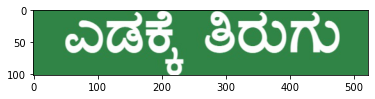

In [10]:
for i in temp_col:
    plt.imshow(i)
    plt.show()

In [11]:
def consec_zero(hist_row):
    res=[]
    count=0
    prev=hist_row[0]
    for i in range(len(hist_row)):
        if hist_row[i]==0:
            count+=1
            prev=0
        else:
            if prev==0:
                res.append(count)
                count=0
            prev=hist_row[i]
    res.append(count) 
    return res

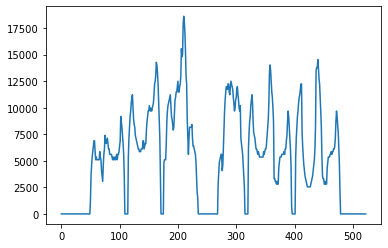

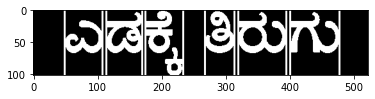

In [12]:
word_seg_img=[]
word_seg_col_img=[]
out=[]
for i in range(len(line_seg_img)):
    hist_row = np.sum(line_seg_img[i], axis = 0)
    plt.plot(hist_row)
    plt.show()
    
    out+=consec_zero(hist_row)
    
    #drawing vertical lines were the sum of pixels is less than the threshold
    H,W = line_seg_img[i].shape
    th=1
    th1=H//3
    uppers = [y for y in range(W-1) if hist_row[y]<=th and hist_row[y+1]>th]
    lowers = [y for y in range(W-1) if hist_row[y]>th and hist_row[y+1]<=th]

    for y in uppers:
        cv2.line(line_seg_img[i], (y,0), (y,H), (255,255,255), 2)

    for y in lowers:
        cv2.line(line_seg_img[i], (y,0), (y,H), (255,255,255), 2)

    plt.imshow(line_seg_img[i],cmap='gray')
    plt.show()
    
    #getting the cordinates of the ROI
    word_wise=[]
    for k in range(len(uppers)):
        temp=[uppers[k],0,lowers[k]-uppers[k],H] #x,y,w,h
        word_wise.append(temp)
    
    temp=[]
    crop(line_seg_col_img[i],word_wise,temp)
    word_seg_col_img.append(temp)

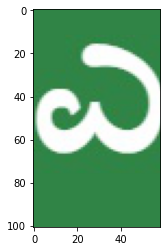

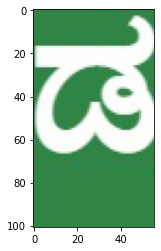

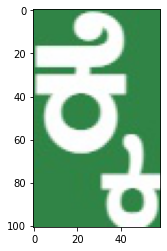

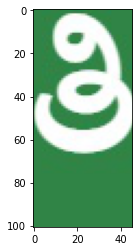

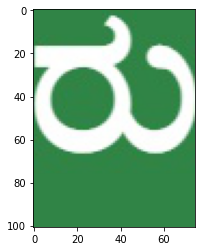

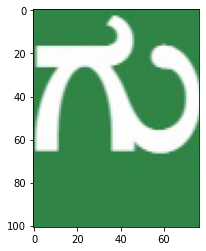

In [13]:
for j in word_seg_col_img:
    for i in j:
        plt.imshow(i,cmap="gray")
        plt.show()

[1 0 0 1 0 0 1]


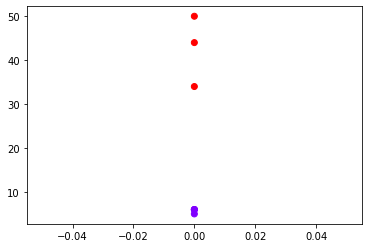

In [14]:
#k-means clustering
X=[]
for i in range(len(out)):
    X.append([0,out[i]])

X=np.array(X) 
  
#creating the an object of sklearn.cluster.KMeans class    
kmeans=KMeans(n_clusters=2)    
  
#passing the data to the model  
kmeans.fit(X)  
   
#Printing the predicted values
res=kmeans.labels_
print(kmeans.labels_)  
  
#Plotting the data based upon their predicted cluster  
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')  
plt.show() 

In [15]:
dict={1:'ಅ',2:'ಆ',3:'ಇ',4:'ಈ',5:'ಉ',6:'ಊ',7:'ಋ',8:'ಋೂ',9:'ಎ',10:'ಏ',11:'ಐ',12:'ಒ',13:'ಓ',14:'ಔ',15:'ಅಂ',16:'ಅಃ',17:'ಕ',18:'ಕಾ',19:'ಕಿ',20:'ಕೀ',21:'ಕು',22:'ಕೂ',23:'ಕೃ',24:'ಕೆ',25:'ಕೇ',26:'ಕೊ',27:'ಕೋ',28:'ಕಂ',29:'ಖ',30:'ಖಿ',31:'ಖೆ',32:'ಗ್',33:'ಗ',34:'ಗಾ',35:'ಗಿ',36:'ಗು',37:'ಗೂ',38:'ಗೆ',39:'ಗೇ',40:'ಗೋ',41:'ಗೌ',42:'ಗಂ',43:'ಘ',44:'ಘಾ',45:'ಘ',46:'ಘಂ',47:'ಚ',48:'ಚಾ',49:'ಚಿ',50:'ಚೆ',51:'ಚಂ',52:'ಛ',53:'ಜ',54:'ಜಾ',55:'ಜಿ',56:'ಜೀ',57:'ಜು',58:'ಜೆ',59:'ಜಿ',60:'ಜಾ',61:'ಟ',62:'ಟಾ',63:'ಟಿ',64:'ಟೀ',65:'ಟು',66:'ಟೆ',67:'ಟೇ',68:'ಟೋ', 69:'ಡ',70:'ಡಾ',71:'ಡಿ',72:'ಡು',73:'ಡೆ',74:'ಡೇ',75:'ಡೋ',76:'ಢ',77:'ಢಾ',78:'ಣ್',79:'ಣ',80:'ಣಿ',81:'ಣೇ',82:'ತ',83:'ತಾ',84:'ತಿ',85:'ತೀ',86:'ತು',87:'ತ್ತು',88:'ತೆ',89:'ತೆೋ',90:'ಥ',91:'ಥಾ',92:'ಥಿ',93:'ದ್',94:'ದ',95:'ದಾ',96:'ದಿ',97:'ದೀ',98:'ದು',99:'ದೃ',100:'ದೆ',101:'ದೇ',102:'ದೊ',103:'ದೌ',104:'ದಂ',105:'ಧ',106:'ಧಿ',107:'ಧು',108:'ನ್',109:'ನ',110:'ನಾ',111:'ನಿ',112:'ನೀ',113:'ನು',114:'ನೂ',115:'ನೆ',116:'ನೇ',117:'ನೈ',118:'ನೊ',119:'ನೋ',120:'ನಂ',121:'ಪ್',122:'ಪ',123:'ಪಾ',124:'ಪಿ',125:'ಪು',126:'ಪೂ',127:'ಪೆ',128:'ಪೇ',129:'ಪೋ',130:'ಪೌ',131:'ಪಂ',132:'ಫ್',133:'ಫ',134:'ಫಿ',135:'ಫೀ',136:'ಫೆ',137:'ಫೇ',138:'ಬ್',139:'ಬ',140:'ಬಾ',141:'ಬಿ',142:'ಬೀ',143:'ಬು',144:'ಬೂ',145:'ಬೆ',146:'ಬೇ',147:'ಬೈ',148:'ಬಂ',149:'ಭ',150:'ಭಾ',151:'ಭಿ',152:'ಭು',153:'ಭೆ',154:'ಬೇ',155:'ಬೈ',156:'ಭಂ',157:'ಮ್',158:'ಮ',159:'ಮಾ',160:'ಮಿ',161:'ಮೀ',162:'ಮು',163:'ಮೂ',164:'ಮೆ',165:'ಮೇ',166:'ಮೊ',167:'ಮೋ',168:'ಮಂ',169:'ಯ',170:'ಯಿ',171:'ಯು',172:'ಯೂ',173:'ಯೇ',174:'ಯೋ',175:'ಯಂ',176:'ರ',177:'ರಾ',178:'ರಿ',179:'ರೀ',180:'ರು',181:'ರೂ',182:'ರೃ',183:'ರೆ',184:'ರೇ',185:'ರೈ',186:'ರೋ',187:'ರಂ',188:'ಲ್',189:'ಲ',190:'ಲಾ',191:'ಲಿ',192:'ಲೀ',193:'ಲು',194:'ಲೂ',195:'ಲೆ',196:'ಲೇ',197:'ಲೋ',198:'ಲಂ',199:'ಳ',200:'ಳಾ',201:'ಳಿ',202:'ಳು',203:'ಳೂ',204:'ಳೆ',205:'ಳೇ',206:'ವ್',207:'ವ',208:'ವಾ',209:'ವಿ',210:'ವು',211:'ವೆ',212:'ವೇ',213:'ವಂ',214:'ಶ್',215:'ಶ',216:'ಶಾ',217:'ಶಿ',218:'ಶೀ',219:'ಶು',220:'ಶೇ',221:'ಶಂ',222:'ಷ',223:'ಷಾ',224:'ಷಿ',225:'ಸ್',226:'ಸ',227:'ಸಾ',228:'ಸಿ',229:'ಸೀ',230:'ಸು',231:'ಸೂ',232:'ಸೆ',233:'ಸೇ',234:'ಸೈ',235:'ಸೊ',236:'ಹಾ',237:'ಹ',238:'ಹೆ',239:'ಷ',240:'ಕ್ಕೆ'}

In [16]:
new_model=load_model('C:/Users/ampra/Capstone/model_seq1.h5')

out=[]
for i in word_seg_col_img:
    for j in i:
        img = cv2.resize(j,(32,32))
        pred=np.argmax(new_model.predict(img[None]), axis=-1)
        out.append(dict[pred[0]+1]) 
    out.append(" ")
out.pop()
print(out)

['ಎ', 'ಡ', 'ಕ್ಕೆ', 'ತಿ', 'ರು', 'ಗು']


In [17]:
res=res.tolist()
res.pop()
res.pop(0)
if res[1]==1:
    target=0
else:
    target=1
print(res)

[0, 0, 1, 0, 0]


In [18]:
j=1
text=""+out[0]

for i in range(len(res)):
    if out[j]!=" ":
        if res[i]==target:
            text+=" "
        text+=out[j]
    j+=1

print(text)

ಎಡಕ್ಕೆ ತಿರುಗು


In [19]:
translator = Translator()
out = translator.translate(text,dest="en")
Text = out.text
print(Text)
TTS = gTTS(text=Text, lang="en-IN")
TTS.save("voice.mp3")
playsound("voice.mp3")
os.remove("voice.mp3")

Turn left
